In [ ]:
# if monarch-kg.tar.gz is not in the current directory, download it
import os
if not os.path.exists('monarch-kg.tar.gz'):
        !wget https://data.monarchinitiative.org/monarch-kg/2024-02-13/monarch-kg.tar.gz
if not os.path.exists('monarch-kg_edges.tsv') or not os.path.exists('monarch-kg_nodes.tsv'):
        !tar -xvzf monarch-kg.tar.gz

In [ ]:
from grape import Graph
g = Graph.from_csv(
        edge_path="monarch-kg_edges.tsv",
        node_path="monarch-kg_nodes.tsv",
        node_list_separator="\t",
        edge_list_separator="\t",
        node_list_header=True,  # Always true for KG-Hub KGs
        edge_list_header=True,  # Always true for KG-Hub KGs
        nodes_column='id',  # Always true for KG-Hub KGs
        node_list_node_types_column='category',  # Always true for KG-Hub KGs
        node_types_separator='|',
        sources_column='subject',  # Always true for KG-Hub KGs
        destinations_column='object',  # Always true for KG-Hub KGs
        edge_list_edge_types_column='predicate',
        directed=False,
        name='Monarch KG Feb 2024',
        verbose=True
)
g

### Get main component

In [ ]:
mc = g.remove_components(top_k_components=1)
mc

### Make LINE embeddings and visualize

In [ ]:
from grape.embedders import FirstOrderLINEEnsmallen
line_embedding = FirstOrderLINEEnsmallen().fit_transform(mc)

### Write out LINE embeddings with metadata

In [6]:
import pyarrow as pa
import pyarrow.parquet as pq
import yaml
import json

# write metadata into the parquet file
line_embedding_parquet = pa.Table.from_pandas(line_embedding)
metadata_dict = yaml.safe_load(open("line_embedding.yaml", 'r'))
metadata_json = json.dumps(metadata_dict)
metadata_bytes = metadata_json.encode('utf-8')
# Store the serialized metadata as a single entry in the metadata dictionary
custom_metadata = {'venomx_metadata': metadata_bytes}

# Add the custom metadata to the table's schema
line_embedding_parquet = line_embedding_parquet.replace_schema_metadata(custom_metadata)
# write the table to a Parquet file
pq.write_table(line_embedding_parquet, 'line_embedding.parquet')

### Visualize LINE embeddings

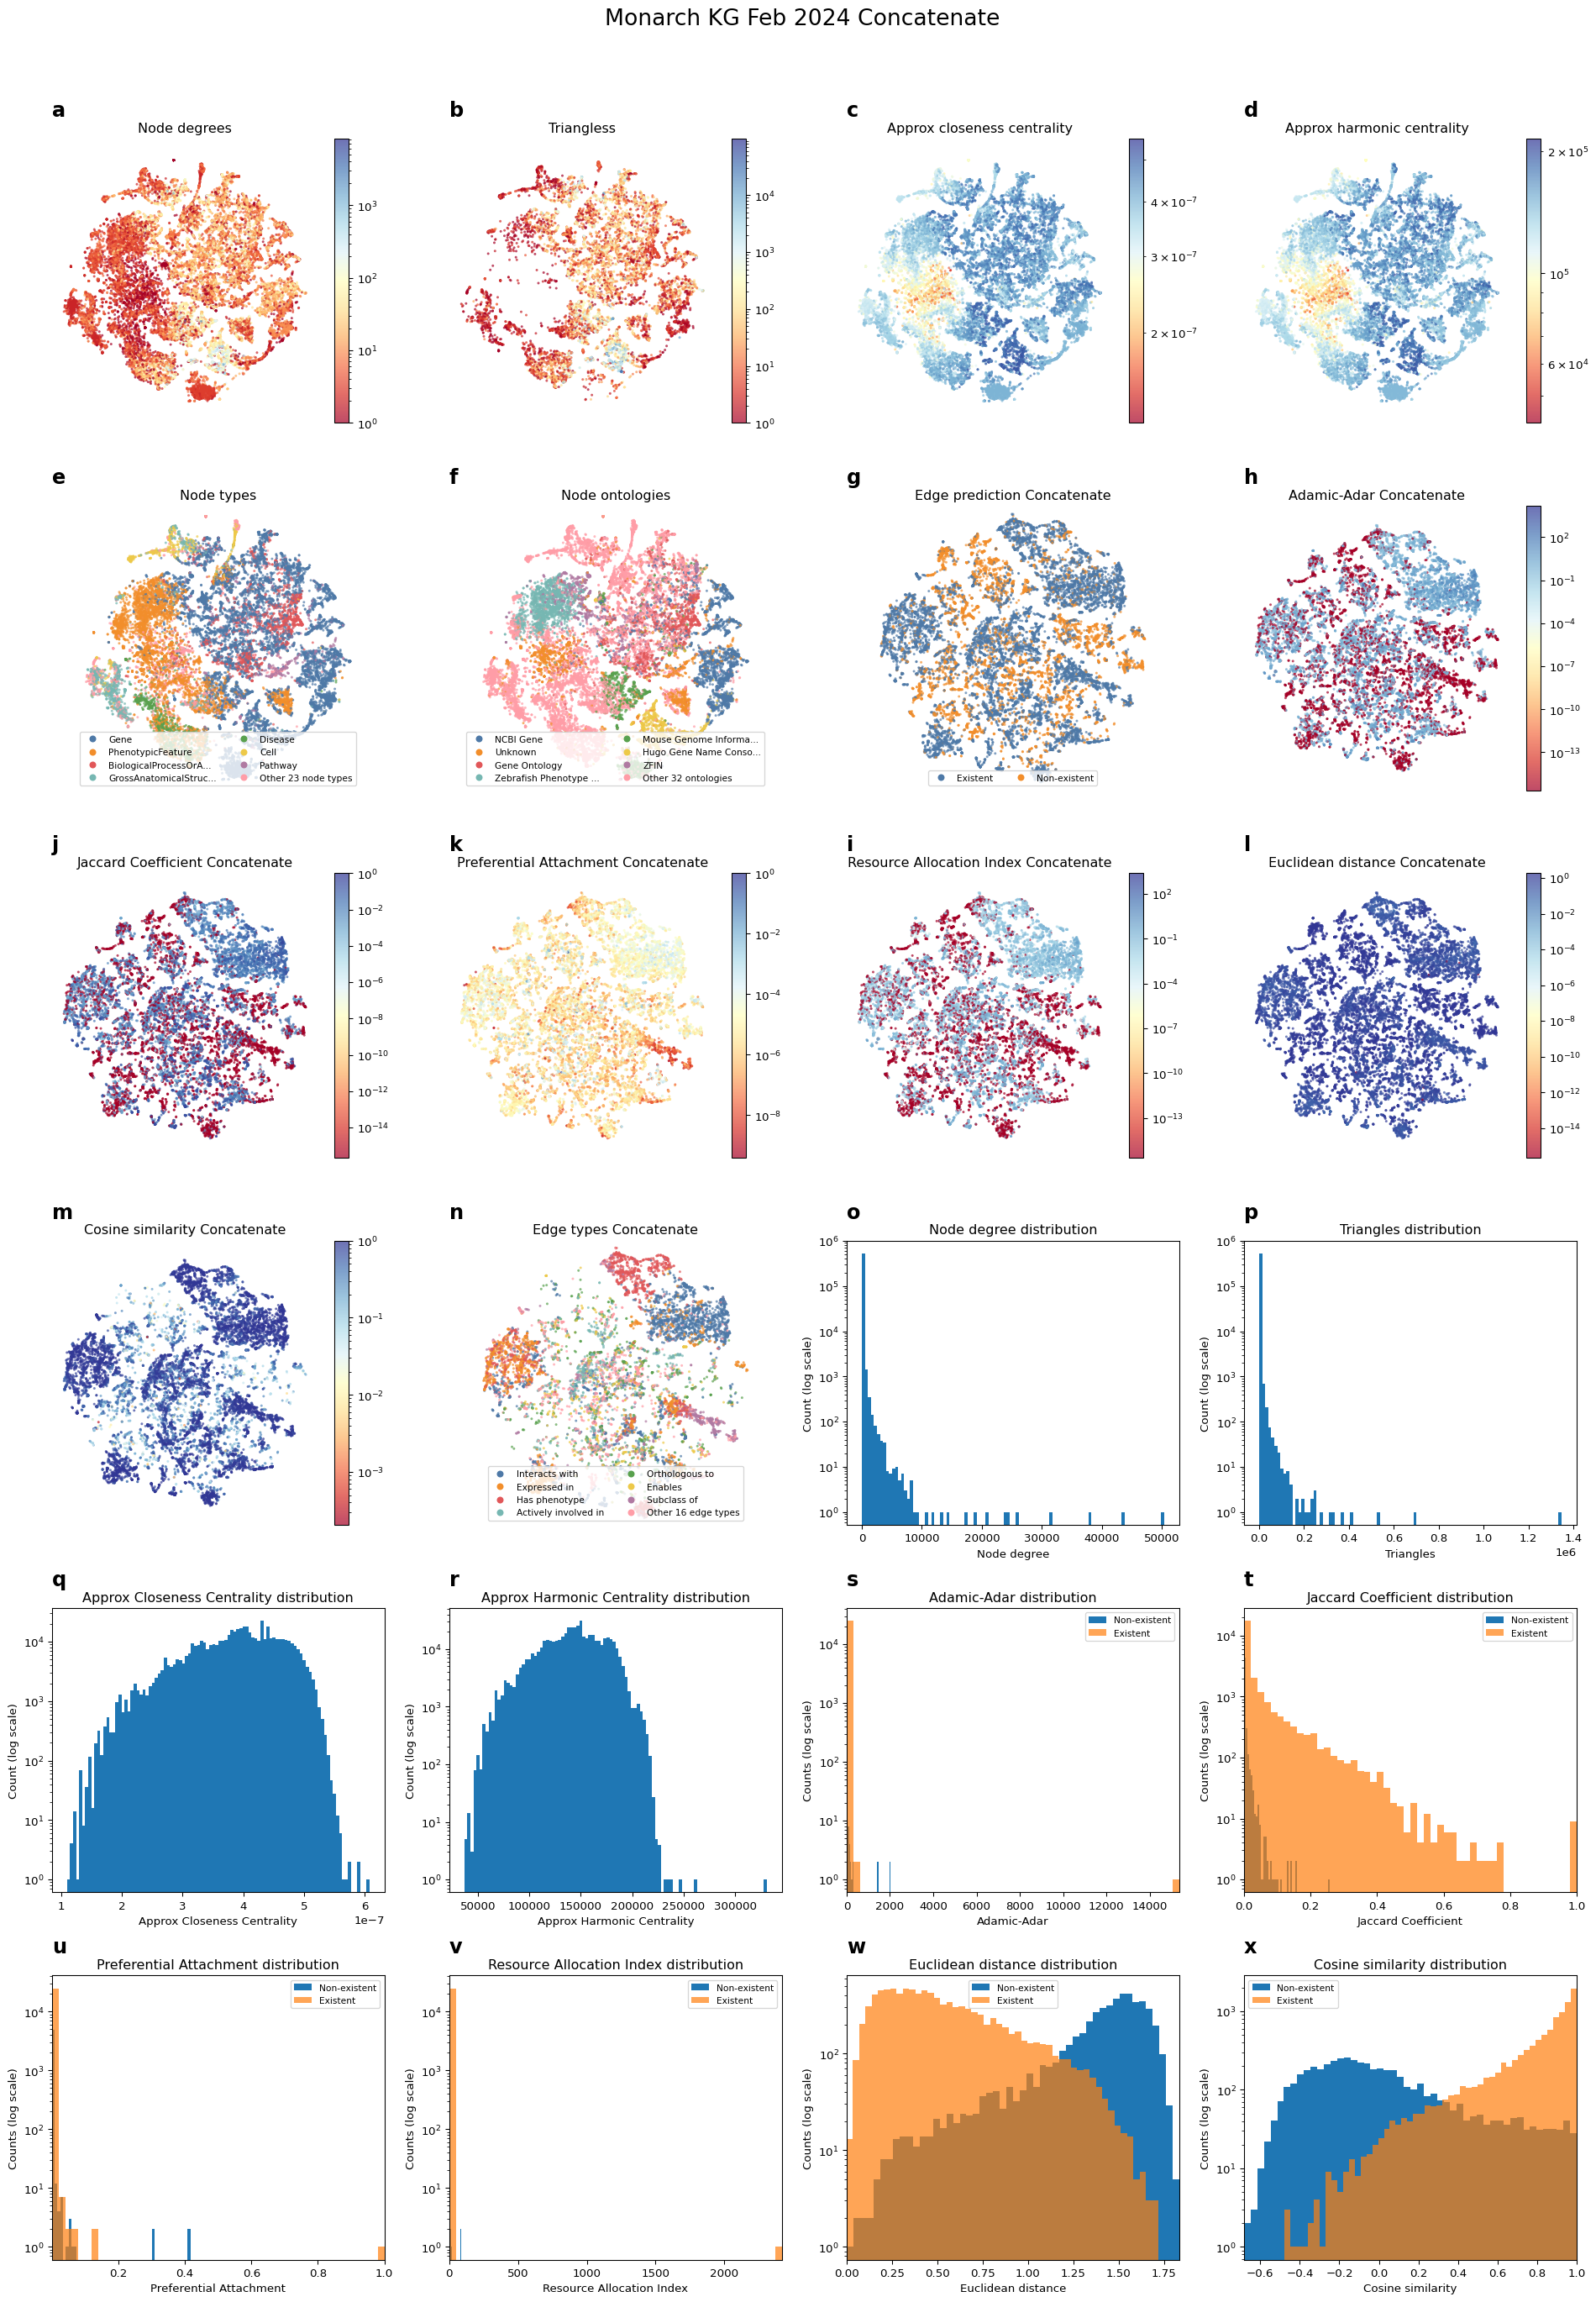

In [25]:
from grape import GraphVisualizer
GraphVisualizer(mc).fit_and_plot_all(line_embedding)

In [ ]:
from grape.embedders import DeepWalkSkipGramEnsmallen
deepwalk_embedding = DeepWalkSkipGramEnsmallen().fit_transform(mc)
# write out the embeddings
deepwalk_embedding.get_all_node_embedding()[0].to_csv('deepwalk_embedding.csv.gz', compression='gzip')
deepwalk_embedding.get_all_node_embedding()[0].to_parquet('deepwalk_embedding.parquet', engine='pyarrow')

In [ ]:
import pyarrow as pa
import yaml
import json

deepwalk_parquet_table = pa.Table.from_pandas(deepwalk_embedding)

metadata_dict = yaml.safe_load(open("deepwalk_embedding.yaml", 'r'))
metadata_json = json.dumps(metadata_dict)
metadata_bytes = metadata_json.encode('utf-8')
# Store the serialized metadata as a single entry in the metadata dictionary
custom_metadata = {'venomx_metadata': metadata_bytes}

# Add the custom metadata to the table's schema
table = deepwalk_parquet_table.replace_schema_metadata(custom_metadata)
table.schema.metadata

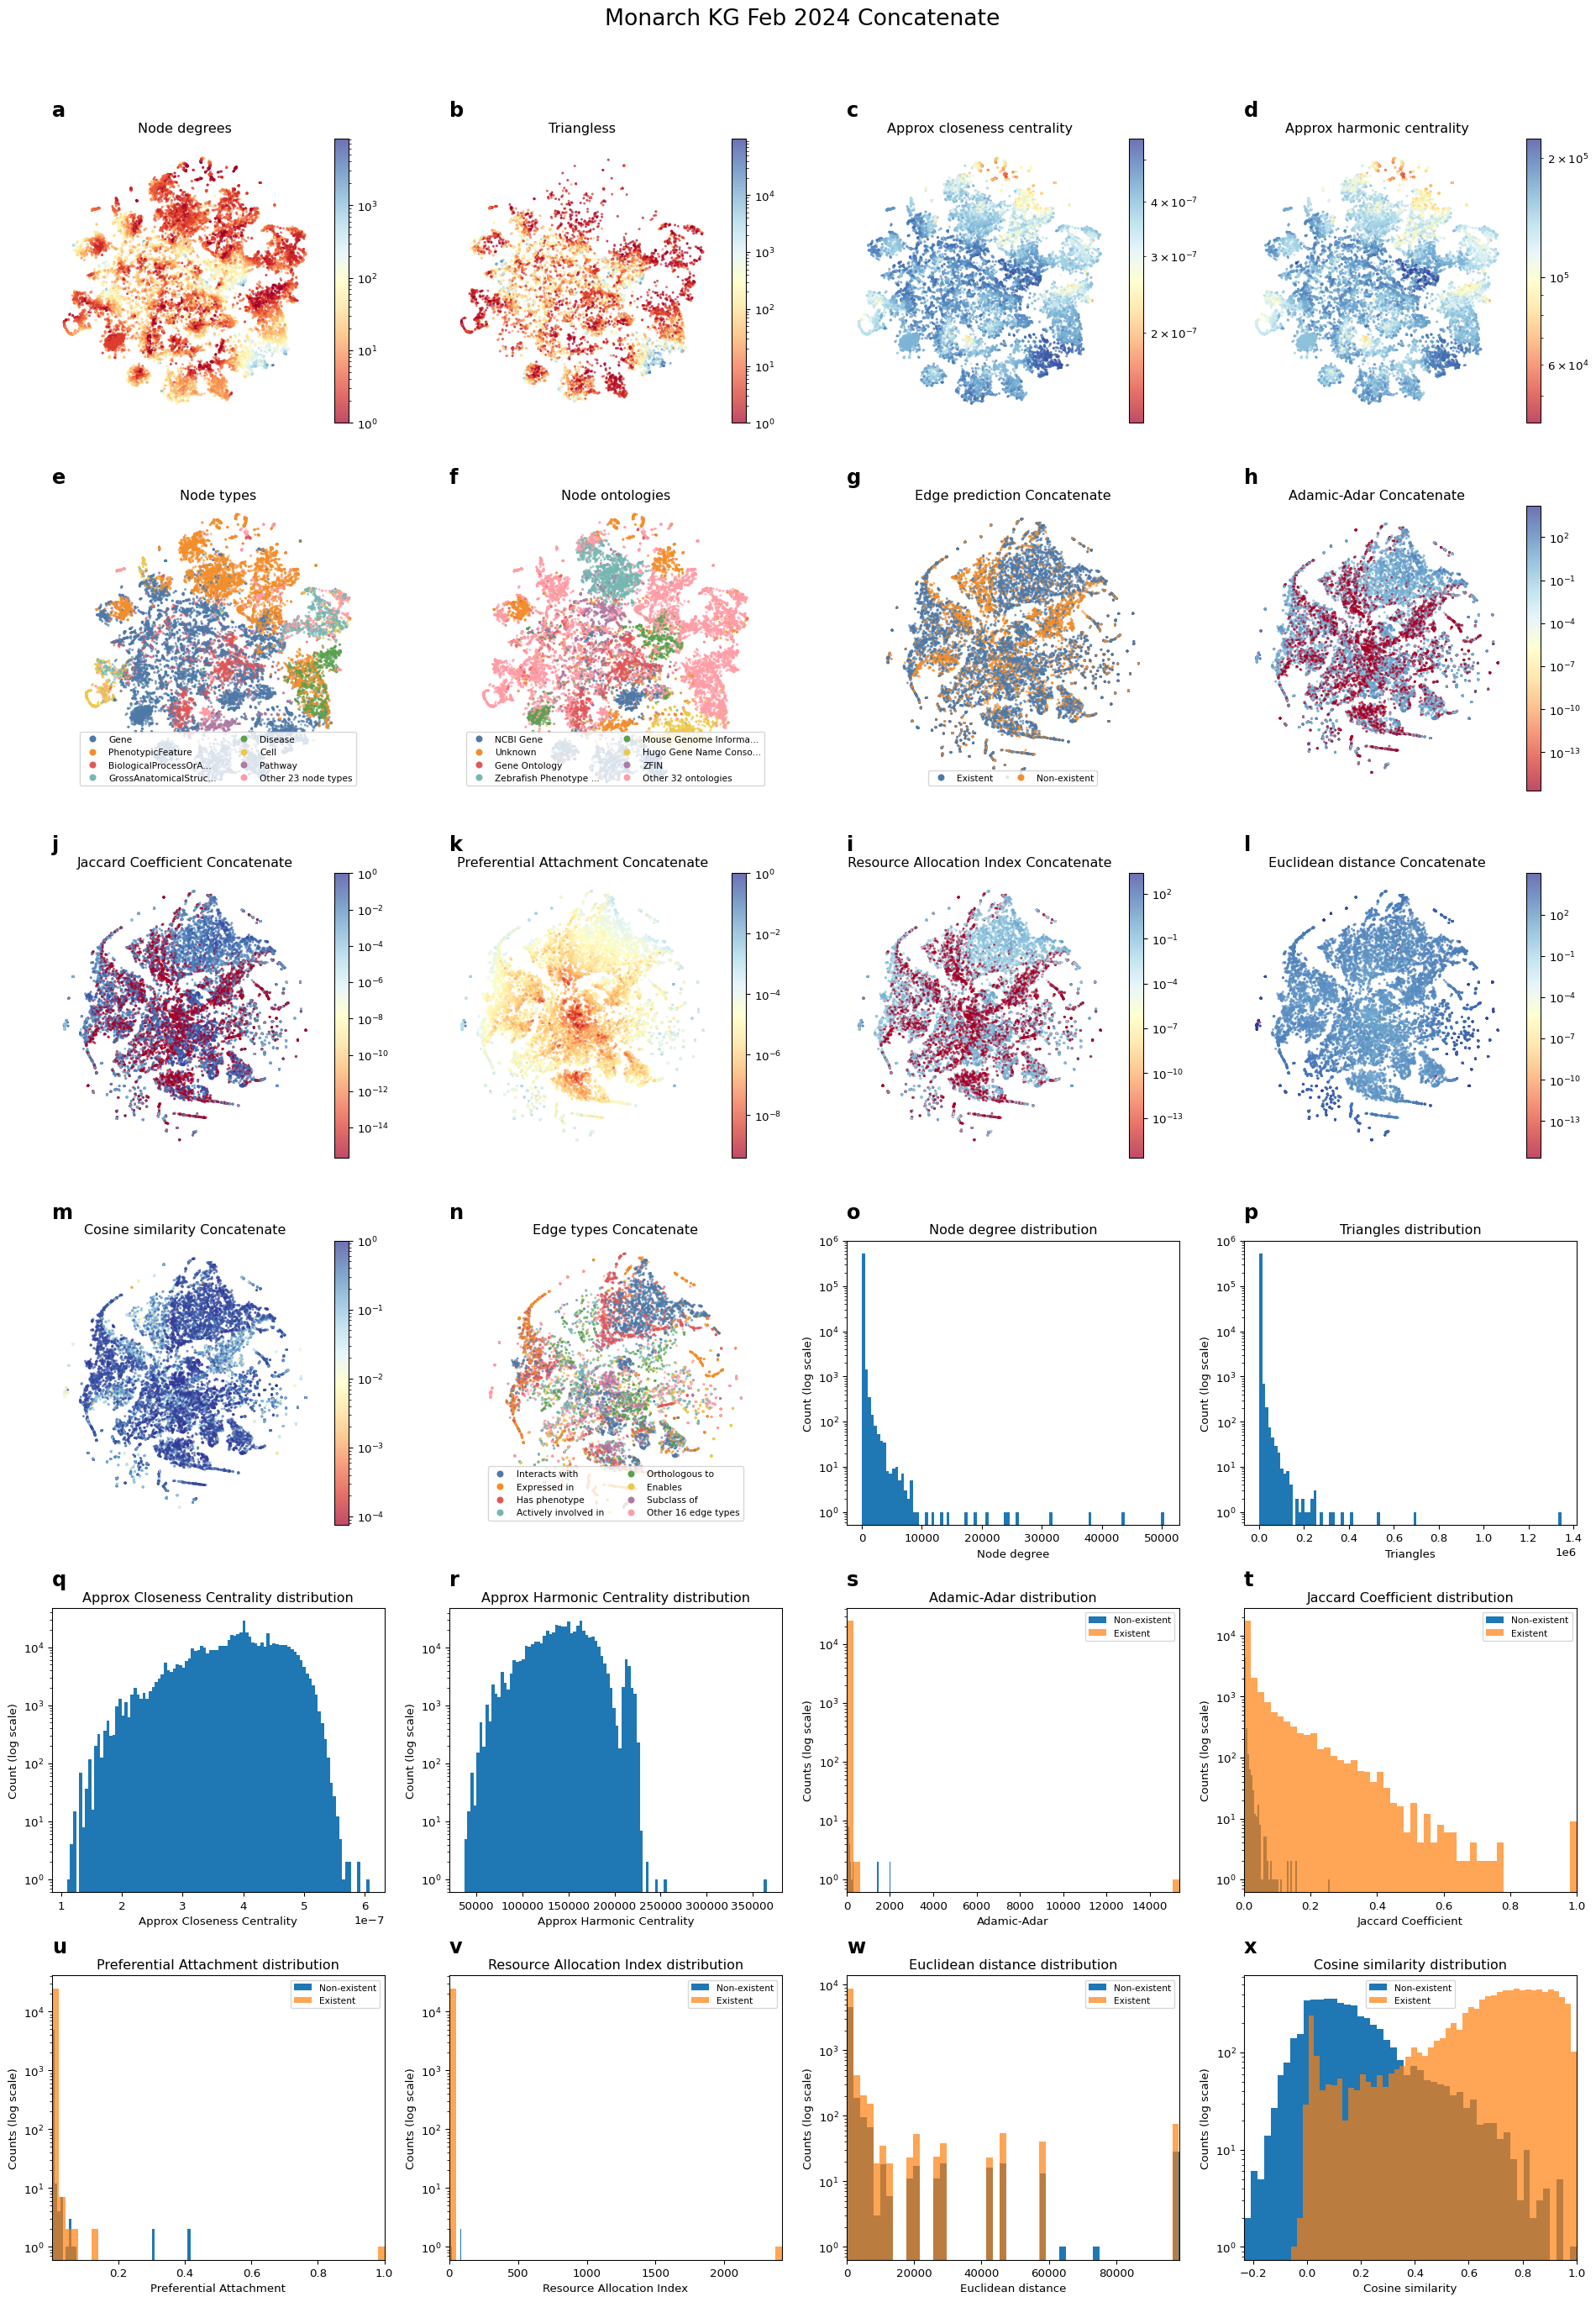

In [24]:
from grape import GraphVisualizer
GraphVisualizer(mc).fit_and_plot_all(deepwalk_embedding.get_all_node_embedding()[0])

### Upload embeddings to Hugging Face

In [9]:
from huggingface_hub import create_repo
repo_id = "translator-ml/monarch_kg_embeddings"
create_repo(repo_id, repo_type="dataset")

RepoUrl('https://huggingface.co/datasets/translator-ml/monarch_kg_embeddings', endpoint='https://huggingface.co', repo_type='dataset', repo_id='translator-ml/monarch_kg_embeddings')

In [12]:
from huggingface_hub import HfApi
api = HfApi()

for file in ["line_embedding.yaml", "line_embedding.parquet",
             "deepwalk_embedding.yaml", "deepwalk_embedding.parquet",
             "embed_monarch.ipynb"]:
    api.upload_file(
        path_or_fileobj=file,
        path_in_repo=file,
        repo_id=repo_id,
        repo_type="dataset",
    )

line_embedding.parquet:   0%|          | 0.00/276M [00:00<?, ?B/s]

deepwalk_embedding.parquet:   0%|          | 0.00/276M [00:00<?, ?B/s]